In [1]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from xgboost import XGBClassifier as XGB
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import ExtraTreeClassifier as ExtraTree
from sklearn.ensemble import ExtraTreesClassifier as ExtraTrees
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import RidgeClassifier as Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.models import Sequential

In [2]:
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
SCALED_FEATURES = 'scaled_features.csv'
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"
config = Configuration.load_json(CONFIG_FILE)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
tf.random.set_seed(1)

In [7]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(df.shape)
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df.head()

(1260, 71)


,File,Gender,Emotion,Emotion_Id,spikes_mel_spect,mean_mel_spect,min_mel_spect,max_mel_spect,var_mel_spect,std_mel_spect,spikes_chroma_stft,mean_chroma_stft,var_chroma_stft,std_chroma_stft,spikes_rms,mean_rms,max_rms,var_rms,std_rms,spikes_spec_cent,mean_spec_cent,min_spec_cent,max_spec_cent,var_spec_cent,std_spec_cent,spikes_spec_bw,mean_spec_bw,min_spec_bw,max_spec_bw,var_spec_bw,std_spec_bw,spikes_spec_rolloff,mean_spec_rolloff,min_spec_rolloff,max_spec_rolloff,var_spec_rolloff,std_spec_rolloff,spikes_spec_cont,mean_spec_cont,min_spec_cont,max_spec_cont,var_spec_cont,std_spec_cont,spikes_zcr,mean_zcr,min_zcr,max_zcr,var_zcr,std_zcr,sum_zcr,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,s1_an_1,m,anger,0,1443,5.470246,4.425599e-10,2683.060303,2835.492676,53.249344,750,0.402497,0.097249,0.311847,83,0.129479,0.340202,0.007750,0.088035,58,1814.026368,812.639867,4084.492417,437557.880517,661.481580,69,1834.495092,1104.902824,2673.005407,154644.510964,393.248663,71,3811.157227,904.394531,6707.592773,2.016124e+06,1419.902686,344,22.718679,7.062807,51.588313,82.005473,9.055687,65,0.093647,0.026855,0.269531,0.001995,0.044666,13.766113,-171.056549,115.938042,-28.566433,21.314878,-26.507704,10.144446,-22.394417,-6.446075,-20.058737,-9.614692,-15.731797,-8.805966,-2.915169,-12.226694,-5.387331,-4.913488,-9.523164,-1.791623,-3.507744,0.083974
1,s1_an_2,m,anger,0,1297,4.795432,3.266728e-10,1598.459473,1602.659546,40.033230,578,0.369817,0.094729,0.307780,64,0.122001,0.275363,0.007222,0.084985,46,1813.929245,1077.773997,4802.078139,517671.206155,719.493715,46,1772.517500,1209.119846,2615.316302,160594.827485,400.742845,48,3602.609923,1711.889648,7288.989258,2.051509e+06,1432.308845,304,22.243432,5.936659,48.160193,77.321635,8.793272,42,0.095251,0.034668,0.402832,0.004444,0.066661,11.715820,-187.978119,114.721764,-41.258282,22.174334,-12.715221,11.881121,-22.636301,-9.284859,-23.113136,-7.031469,-15.980973,-11.601790,-5.727098,-6.378960,-7.155036,-7.385511,-8.306025,4.346861,-6.595266,-2.742662
1,s1_an_5,m,anger,0,909,6.344573,4.247520e-10,4932.327637,6391.681152,79.947990,536,0.312011,0.098784,0.314300,61,0.140534,0.410695,0.008144,0.090243,50,1577.596083,731.779647,3118.561755,152720.583570,390.794810,47,1621.112545,998.916801,2391.307207,100143.189503,316.454088,62,3149.887457,775.195312,5910.864258,1.215127e+06,1102.328088,304,23.661057,6.420219,50.013285,71.860833,8.477077,52,0.072095,0.033203,0.153809,0.000541,0.023251,8.867676,-180.083939,119.054886,-42.182270,26.999893,-6.590928,8.636041,-17.951387,-20.642817,-24.792250,-4.610571,-18.438587,-11.906024,-3.913879,-11.295942,-3.214928,-6.571509,-0.506520,1.930403,-6.855784,-2.346526
1,s1_an_4,m,anger,0,898,7.300478,3.510179e-10,3062.532715,4610.922363,67.903770,417,0.272837,0.095383,0.308841,58,0.155781,0.308454,0.007771,0.088151,41,1578.663080,989.554541,3072.898800,113822.283518,337.375582,37,1679.770568,1277.610555,2577.918929,89344.835302,298.906064,39,3222.159447,1539.624023,6180.029297,9.498801e+05,974.617910,238,23.566948,8.367288,49.570257,78.338294,8.850892,44,0.068912,0.036621,0.134277,0.000354,0.018807,7.304688,-166.445877,122.271973,-42.199047,19.365204,-21.122906,8.933196,-21.792807,-10.018277,-22.990005,-9.038509,-19.050367,-9.762544,0.404813,-14.561901,-6.730536,-4.809193,-5.546733,2.948940,-6.117626,-3.003350
1,s1_an_3,m,anger,0,1392,3.334237,3.032449e-10,689.850098,542.464478,23.290867,603,0.402758,0.097614,0.312432,57,0.093039,0.258287,0.007551,0.086896,61,1699.189320,1154.867212,2519.734104,118628.430190,344.424782,51,1764.541591,1131.241853,2699.423772,195473.567039,442.123927,57,3558.226103,1604.223633,5770.898438,1.733753e+06,1316.720683,301,21.846660,6.884981,48.784060,66.028699,8.125805,58,0.089708,0.041016,0.129395,0.000406,0.020160,10.675293,-241.878052,123.269180,-36.750164,15.108225,-17.863935,12.1

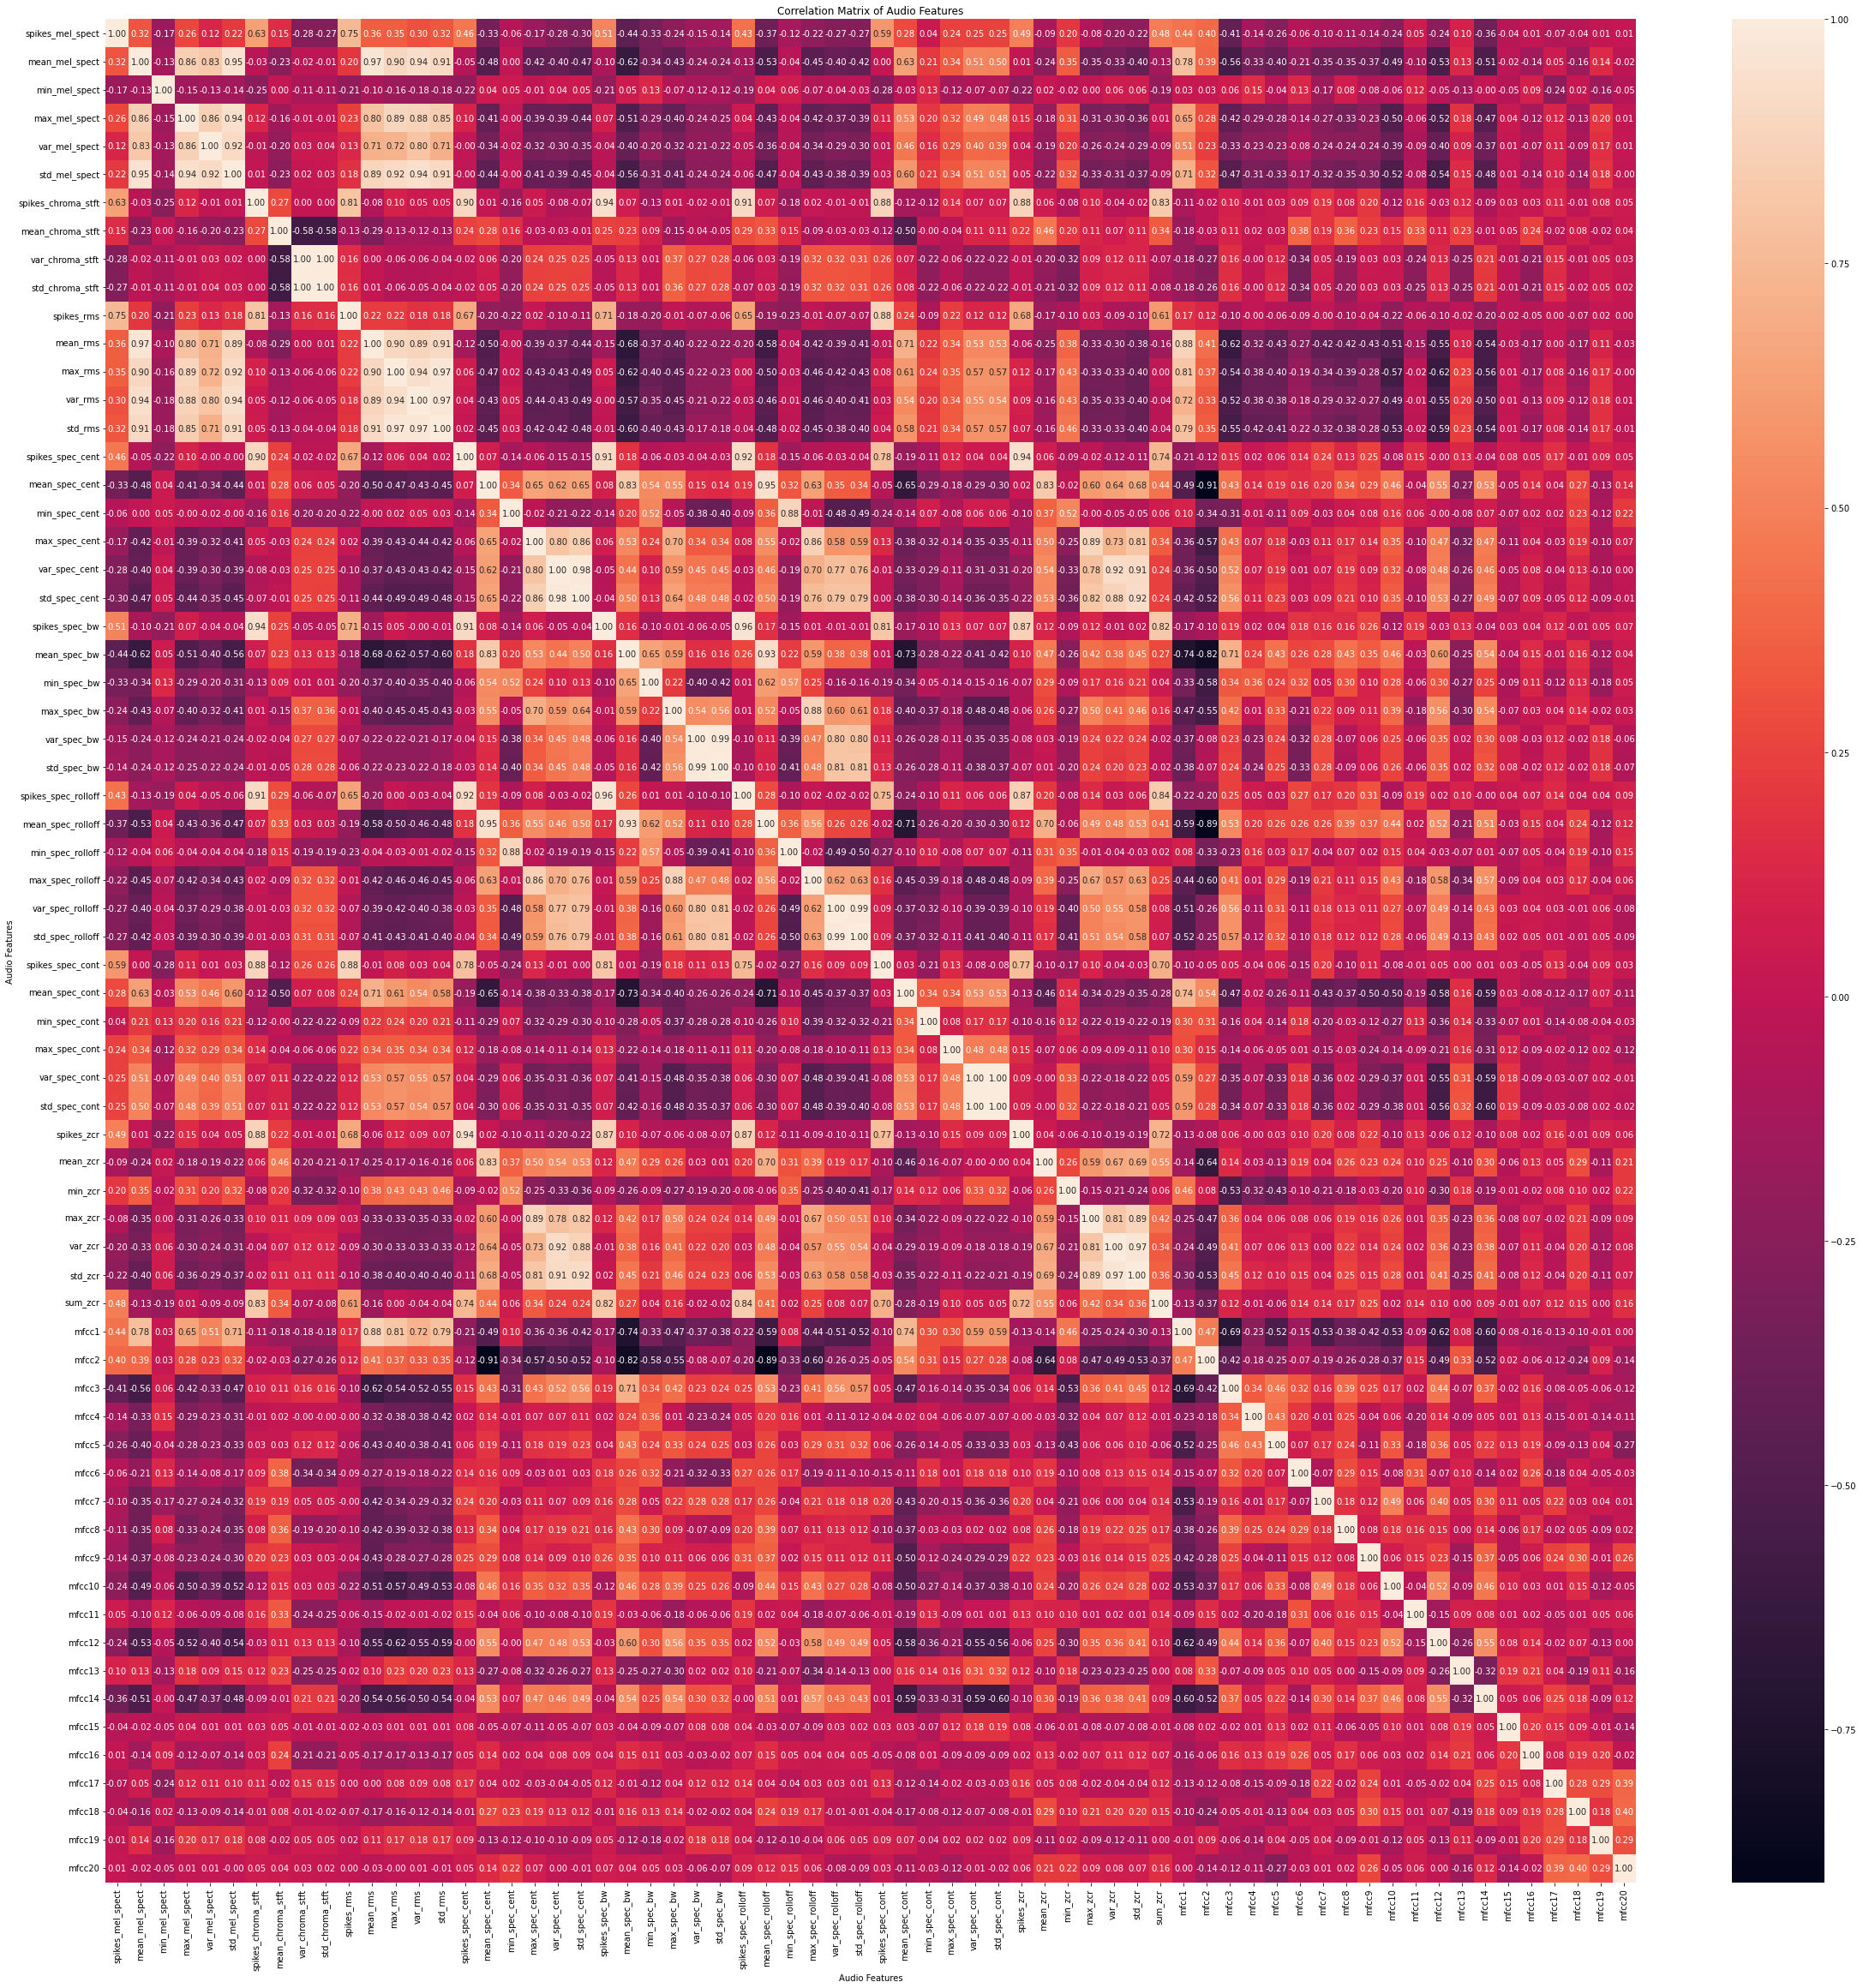

In [8]:
plt.figure(figsize=(40,40))
df_corr = df.iloc[:,4:].corr()
sns.heatmap(df_corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [9]:
def hight_corr_feat_elimination(df_corr):
    corr_pairs = df_corr.unstack()
    # order pairs of features with highest correlations
    strong_pairs = []
    for pair in corr_pairs.items():
        if pair[0][0] != pair[0][1] and abs(pair[1]) > 0.7\
            and ((pair[0][1], pair[0][0]), pair[1]) not in strong_pairs:
            strong_pairs.append(((pair[0][0], pair[0][1]), pair[1]))
    strong_pairs.sort(reverse=True, key=lambda x: abs(x[1]))

    eliminated_feats = set()

    for pair in strong_pairs:
        corr = pair[1]
        f1 = pair[0][0]
        f2 = pair[0][1]

        if corr > 0.7 and \
            f1 not in eliminated_feats and \
            f2 not in eliminated_feats:
            mean_corr_f1 = np.mean(abs(df_corr[f1].values))
            mean_corr_f2 = np.mean(abs(df_corr[f2].values))

            eliminated_feats.add(f1 if mean_corr_f1 > mean_corr_f2 else f2)

    return eliminated_feats

In [10]:
eliminated_feats = hight_corr_feat_elimination(df_corr)
print(len(eliminated_feats))
print(eliminated_feats)

30
{'spikes_rms', 'max_rms', 'mfcc1', 'spikes_zcr', 'var_zcr', 'spikes_spec_cent', 'max_spec_rolloff', 'spikes_spec_bw', 'std_spec_bw', 'mean_spec_cent', 'mean_spec_rolloff', 'mean_rms', 'std_spec_rolloff', 'mean_mel_spect', 'var_rms', 'spikes_spec_cont', 'min_spec_cent', 'std_rms', 'var_spec_rolloff', 'var_spec_cont', 'sum_zcr', 'std_spec_cent', 'std_zcr', 'max_spec_cent', 'spikes_spec_rolloff', 'mean_spec_bw', 'std_mel_spect', 'var_spec_cent', 'var_chroma_stft', 'max_mel_spect'}


In [11]:
[df.drop(feat, inplace=True, axis=1) for feat in eliminated_feats]
num_features = len(df.columns)-4
print(f"Number of features after high correlation elimination: {num_features}")

Number of features after high correlation elimination: 36


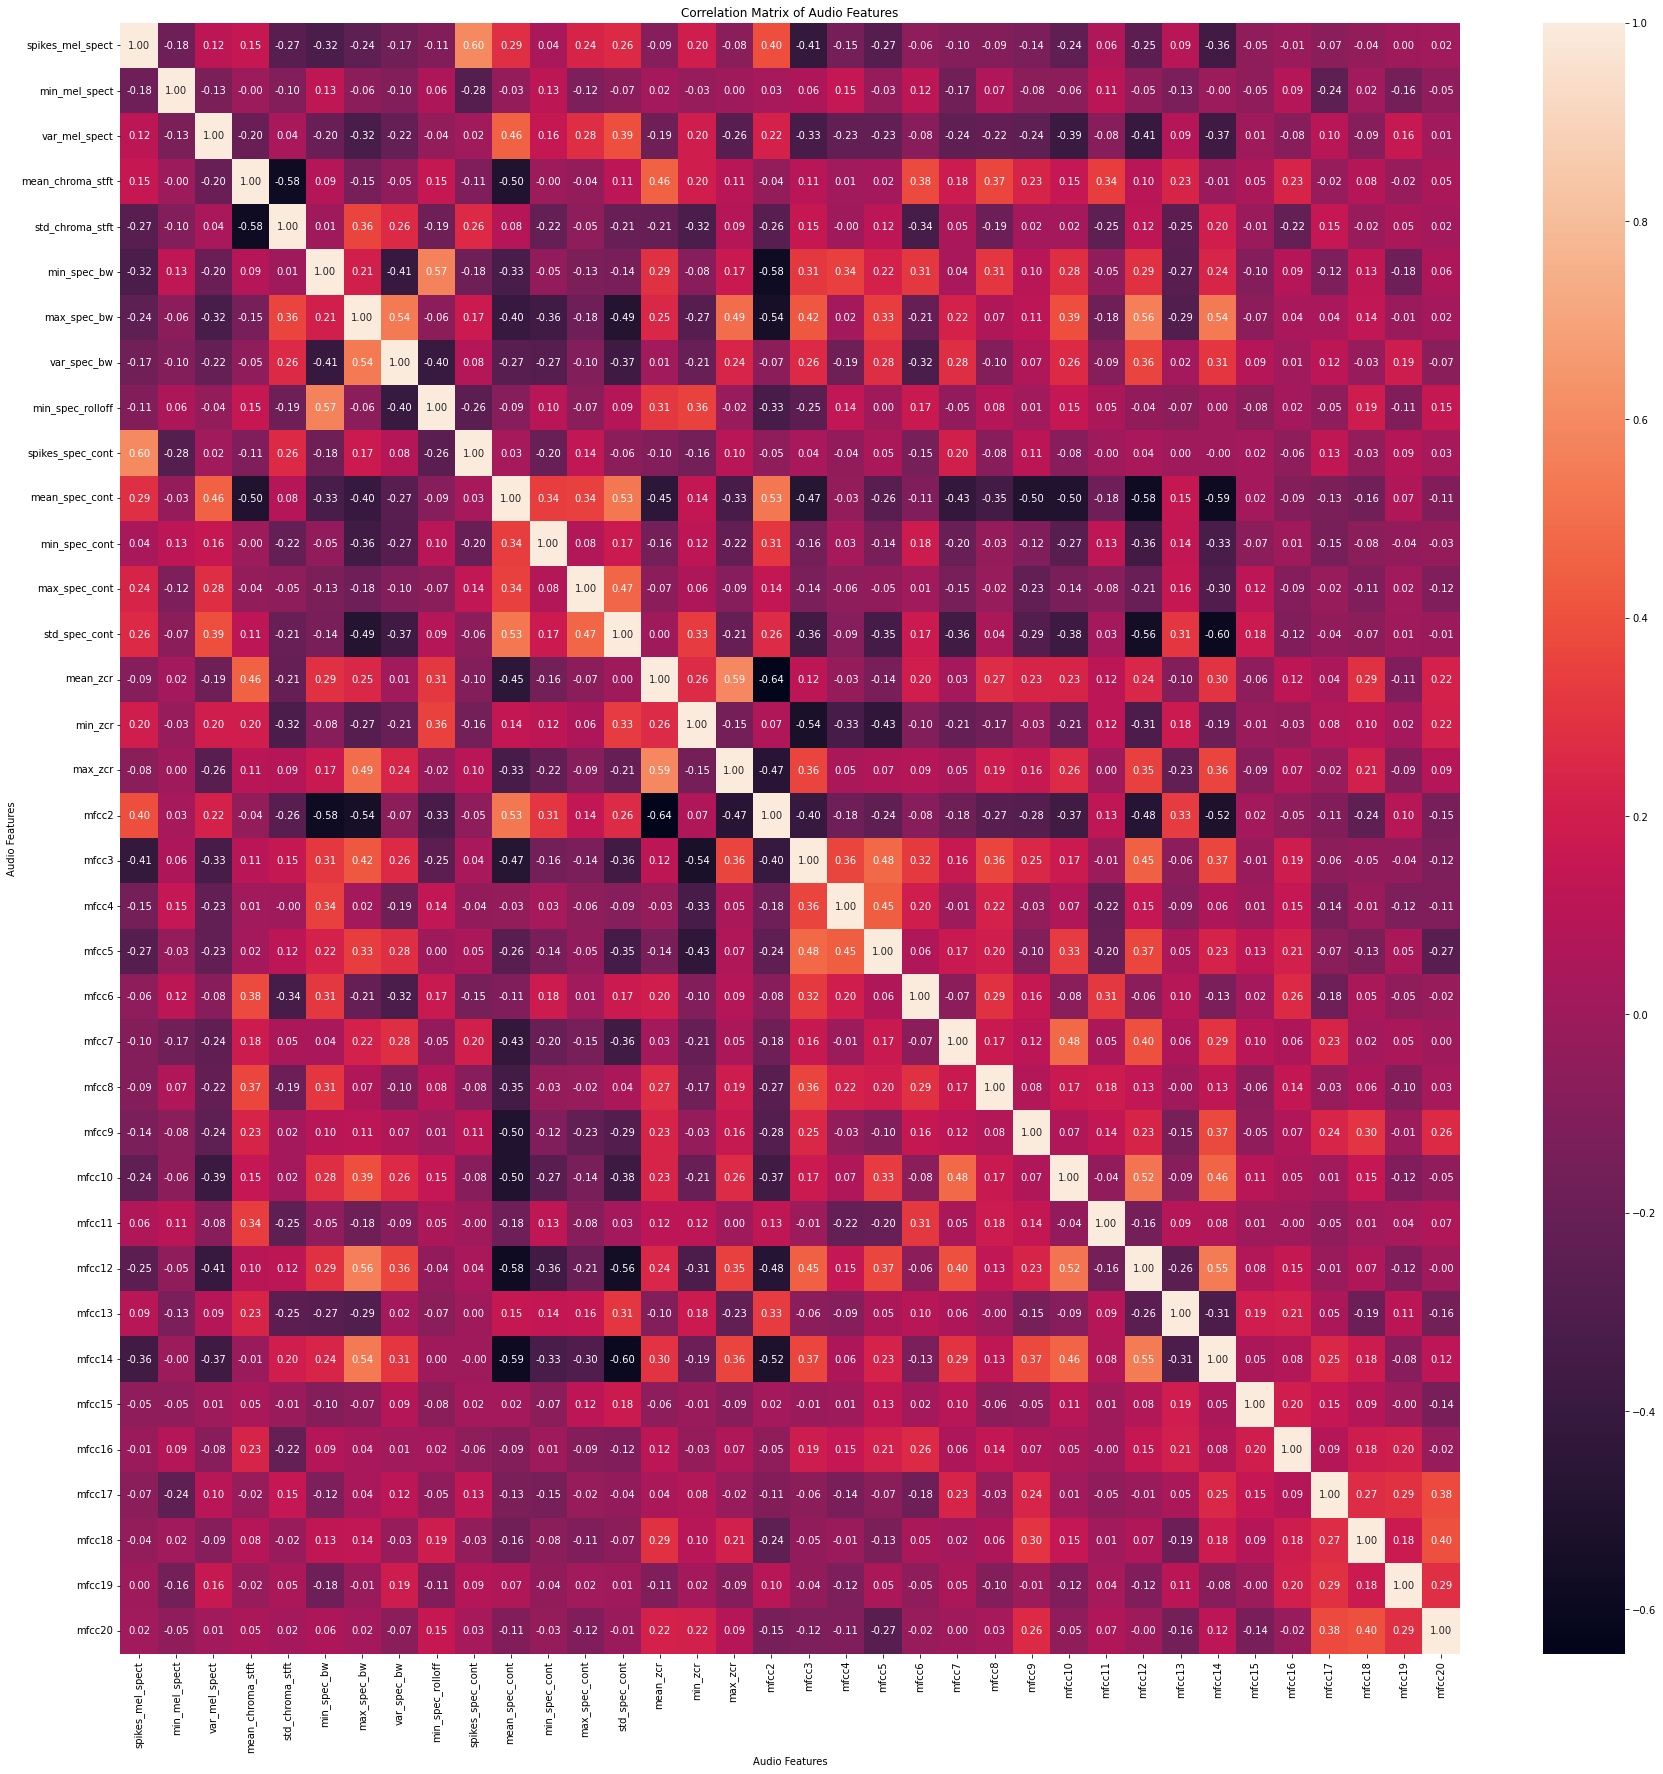

In [8]:
plt.figure(figsize=(30,30))
df_corr = df.iloc[:,4:].corr()
sns.heatmap(df_corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [12]:
data = df.iloc[:,4:]
features = df.columns.values[4:]
labels = df["Emotion_Id"].values

## Compare Scores of Classifiers

In [10]:
def compare_clfs(clfs, data, labels):
    clfs_scores = defaultdict(dict)
    
    for clf in clfs:
        scores = cross_val_score(clf, data, labels, cv=5)
        
        # scores for each fold
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        clfs_scores[clf.__class__.__name__.split("(")[0]] = (mean_score, std_score)
    
    return clfs_scores

In [11]:
%%capture
clfs = [
    DecisionTree(random_state=1, max_features=None),
    ExtraTree(random_state=1, max_features=None),
    RandomForest(random_state=1, max_features=None),
    ExtraTrees(random_state=1, max_features=None),
    XGB(random_state=1, objective="multi:softprob"),
    Ridge(random_state=1)
]

clfs_scores = compare_clfs(clfs, data, labels)

In [12]:
print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean", "Std"]), headers = 'keys'
))

print(f"\nClassifiers Ordered by Lowest Standard Deviation Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][1])
    ), orient="index", columns=["Mean", "Std"]), headers = 'keys'
))

Classifiers Ordered by Highest Mean Accuracy:
                            Mean        Std
----------------------  --------  ---------
ExtraTreesClassifier    0.473185  0.0227786
XGBClassifier           0.459195  0.0425803
RidgeClassifier         0.456037  0.0346476
RandomForestClassifier  0.44833   0.0181348
DecisionTreeClassifier  0.306105  0.0360249
ExtraTreeClassifier     0.262637  0.0310688

Classifiers Ordered by Lowest Standard Deviation Accuracy:
                            Mean        Std
----------------------  --------  ---------
RandomForestClassifier  0.44833   0.0181348
ExtraTreesClassifier    0.473185  0.0227786
ExtraTreeClassifier     0.262637  0.0310688
RidgeClassifier         0.456037  0.0346476
DecisionTreeClassifier  0.306105  0.0360249
XGBClassifier           0.459195  0.0425803


In [13]:
clf = RandomForest(random_state=1, max_features=None)
clf.fit(data, labels)
importance = clf.feature_importances_
importance

array([0.05248834, 0.        , 0.05713542, 0.02090038, 0.02552037,
       0.02337323, 0.02968787, 0.02778026, 0.02282896, 0.0389561 ,
       0.02084587, 0.02072397, 0.02209015, 0.02657564, 0.05519529,
       0.02625052, 0.03791704, 0.029766  , 0.03410204, 0.03216503,
       0.02170937, 0.03761588, 0.02966024, 0.02268666, 0.02550841,
       0.02023621, 0.03100686, 0.02413871, 0.03401716, 0.01722922,
       0.02411803, 0.02308196, 0.02604369, 0.01969976, 0.01902327,
       0.01992208])

## Custom Feature Elimination with Propagation

In [36]:
def feature_elim(data, features, labels, n_features=1):
    data_c = data.copy()
    features = list(features)
    total_features = len(features)
    results = pd.DataFrame(columns=["Mean Acc", "Std Acc"])

    for _ in range(total_features-1, n_features-1, -1):
        acc = pd.DataFrame(columns=["Feature", "Mean Acc", "Std Acc"])
        
        for feat in tqdm(features):
            X_train = data_c.copy()

            X_train.drop(feat, inplace=True, axis=1)

            clf = RandomForest(random_state=1, max_features=None)
            scores = cross_val_score(clf, X_train, labels, cv=5)

            # mean score across all folds
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            acc.loc[feat] = [feat, mean_score, std_score]

        acc_scaled = acc.copy(deep=True)
        acc_scaled[acc_scaled.columns[1]] = minmax_scale(acc_scaled[acc_scaled.columns[1]], (0, 1))
        acc_scaled[acc_scaled.columns[2]] = minmax_scale(acc_scaled[acc_scaled.columns[2]], (0, 1))
        acc_scaled = acc_scaled.values.tolist()
        worse_feat = sorted(acc_scaled, key=lambda x: x[1]*0.5 - x[2]*0.5, reverse=True)[0]
        worse_feat = acc.loc[acc['Feature'] == worse_feat[0]].values[0]
        data_c.drop(worse_feat[0], inplace=True, axis=1)
        features.remove(worse_feat[0])
        results.loc[worse_feat[0]] = [worse_feat[1], worse_feat[2]]

    return results

In [ ]:
custom_feat_elim_df = feature_elim(data, features, labels, 1)
custom_feat_elim_df.to_csv("custom_feat_elim.csv")
custom_feat_elim_df

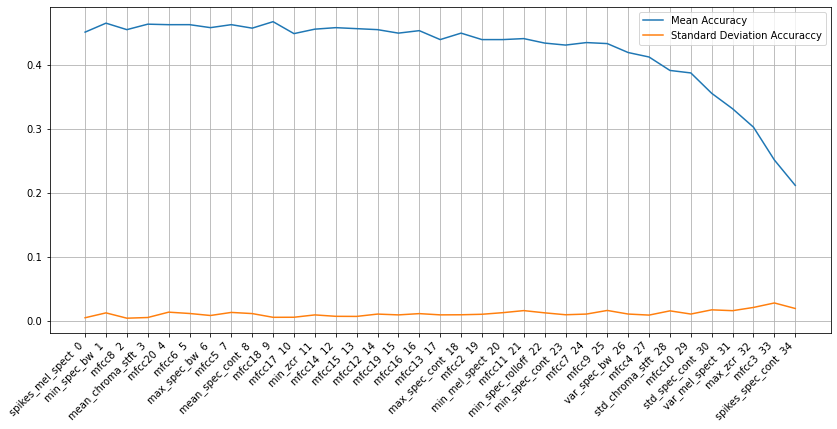

In [9]:
custom_feat_elim_df = pd.read_csv("custom_feat_elim.csv", index_col=0)
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
x_labels = [f"{custom_feat_elim_df.index.values[i]}  {i}" for i in range(len(custom_feat_elim_df.index.values))]
ax.plot(x_labels, custom_feat_elim_df['Mean Acc'].values, label="Mean Accuracy")
ax.plot(x_labels, custom_feat_elim_df['Std Acc'].values, label="Standard Deviation Accuraccy")
plt.legend()

In [10]:
def energy_method(df, energy_perc, column):
    total = np.sum(df[column].values)
    elim_feats = []

    cumulative_val = 0
    for feat, columns in df.iterrows():
        val = columns[column]
        cumulative_val += val
        elim_feats.append(feat)
        if (cumulative_val * 100 / total) >= energy_perc:
            break
    
    return elim_feats

custom_elim_feats = energy_method(custom_feat_elim_df, 80, "Mean Acc")

## Feature Elimination with Backward Propagation

- Less 1 feature

In [18]:
sfs1 = sfs(RandomForest(random_state=1, max_features=None), k_features=num_features-1, forward=False, cv=5, n_jobs=8)
sfs1 = sfs1.fit(data, labels)
print(sfs1.k_score_)
feat_names = set(sfs1.k_feature_names_)
left_out_features = [feat for feat in features if feat not in feat_names]
print(left_out_features)

0.46153892558742804
['mfcc14']


- For All Features

In [19]:
feat_elim = {}
df_train = data.copy()
for i in range(num_features-1, 0, -1):
    sfs1 = sfs(RandomForest(random_state=1, max_features=None), k_features=i, forward=False, cv=5, n_jobs=8)
    sfs1 = sfs1.fit(df_train, labels)
    feat_names = set(sfs1.k_feature_names_)
    eliminated_f = [feat for feat in features if feat not in feat_names and feat not in feat_elim][0]
    feat_elim[eliminated_f] = sfs1.k_score_
    df_train.drop(eliminated_f, inplace=True, axis=1)

In [20]:
feat_elim_df = pd.DataFrame().from_dict(feat_elim, orient="index", columns=["Accuracy"])
feat_elim_df.to_csv('feat_elim.csv')
print(tabulate(feat_elim_df.iloc[:10,:], headers = 'keys'))

                    Accuracy
----------------  ----------
mfcc14              0.461539
mean_chroma_stft    0.459222
min_spec_bw         0.466992
min_spec_rolloff    0.468531
mfcc16              0.464649
min_mel_spect       0.473969
max_spec_cont       0.477878
mfcc7               0.476307
mfcc18              0.471616
mfcc19              0.474738


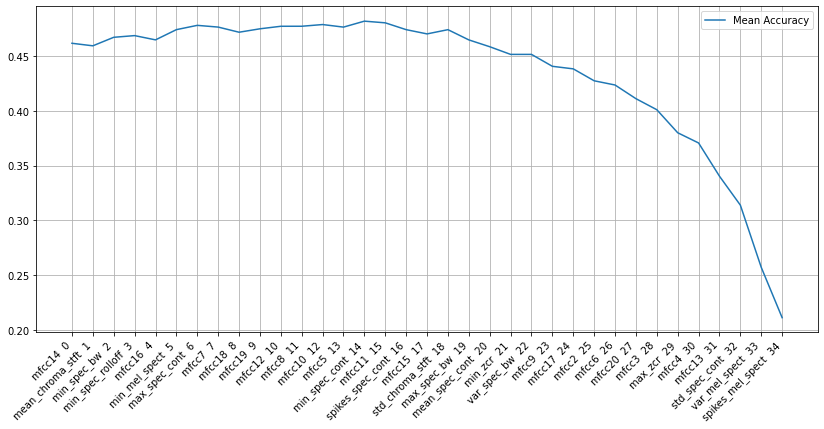

In [11]:
feat_elim_df = pd.read_csv("feat_elim.csv", index_col=0)
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
x_labels = [f"{feat_elim_df.index.values[i]}  {i}" for i in range(len(feat_elim_df.index.values))]
ax.plot(x_labels, feat_elim_df['Accuracy'].values, label="Mean Accuracy")
plt.legend()

In [12]:
elim_feats = energy_method(feat_elim_df, 80, "Accuracy")
common_elim_feats = [x for x in custom_elim_feats if x in elim_feats]
print('Feature Elimination with Propagation - Keeping 80% "Energy"\n')

print(f"Number of Eliminated Features Using:\n\t-Mean Accuracy as the Decider Metric: {len(elim_feats)}")
print(f"\t-Mean and Standard Deviation Accuracy as the Decider Metrics: {len(custom_elim_feats)}\n")
print(f"Common Eliminated Features betwen the two: {len(common_elim_feats)}")

Feature Elimination with Propagation - Keeping 80% "Energy"

Number of Eliminated Features Using:
	-Mean Accuracy as the Decider Metric: 27
	-Mean and Standard Deviation Accuracy as the Decider Metrics: 27

Common Eliminated Features betwen the two: 24


In [13]:
data_elim_feats = data.copy(deep=True)
[data_elim_feats.drop(feat, inplace=True, axis=1) for feat in common_elim_feats]
num_features = len(data_elim_feats.columns)
features = data_elim_feats.columns.values
print(f"Number of Features After Eliminating Common Features: {num_features}")

Number of Features After Eliminating Common Features: 12


## PCA

In [82]:
pca = PCA(random_state=1)
data_scaled = StandardScaler().fit_transform(data)
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
list(explained_variance).sort(reverse=True)
comp_var = {}
for i in range(1, len(explained_variance)+1):
    comp_var[i] = np.sum(explained_variance[:i])
pd.DataFrame().from_dict(comp_var, orient='index', columns=["Total Variance Ratio"])

,Total Variance Ratio
1,0.278434
2,0.395892
3,0.492277
4,0.569408
5,0.621139
6,0.666379
7,0.702078
8,0.731609
9,0.756168
10,0.777623


In [83]:
min_var = .9
threshold = 0.01
prev_exp_var = 0
for num_component, total_exp_var in comp_var.items():
    if total_exp_var >= min_var and abs(total_exp_var - prev_exp_var) <= threshold:
        break
    prev_exp_var = total_exp_var
num_component

20

In [84]:
pca = PCA(random_state=1)
data_scaled_elim = StandardScaler().fit_transform(data_elim_feats)
data_pca_elim = pca.fit_transform(data_scaled_elim)
explained_variance = pca.explained_variance_ratio_
list(explained_variance).sort(reverse=True)
comp_var_elim = {}
for i in range(1, len(explained_variance)+1):
    comp_var_elim[i] = np.sum(explained_variance[:i])
pd.DataFrame().from_dict(comp_var_elim, orient='index', columns=["Total Variance Ratio"])

,Total Variance Ratio
1,0.233440
2,0.369473
3,0.499570
4,0.608859
5,0.695931
6,0.772811
7,0.837638
8,0.889522
9,0.932705
10,0.963016


In [85]:
min_var = .9
threshold = 0.04
prev_exp_var = 0
for num_component_elim, total_exp_var in comp_var_elim.items():
    if total_exp_var >= min_var and abs(total_exp_var - prev_exp_var) <= threshold:
        break
    prev_exp_var = total_exp_var
num_component_elim

10

# Confusion Matrix for Predictions

In [14]:
def get_tick_labels(val, aro):
    if val and aro:
        return [
            '(0, 0) - sadness',
            '(0, 1) - anger, disgust, fear',
            '(1, 1) - happiness, surprise'
        ]
    elif val:
        return [
            '0 - Low Valence',
            '1 - High Valence'
        ]
    elif aro:
        return [
            '0 - Low Arousal',
            '1 - High Arousal'
        ]
    else:
        return [
            '0 - anger',
            '1 - disgust',
            '2 - fear',
            '3 - happiness',
            '4 - sadness',
            '5 - surprise'
        ]

In [15]:
'''
calculate multi-class classification and return related evaluation metrics
'''
def multi_class_classification(y_pred, labels):
    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming_loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews_corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero_one_loss: ", metrics.zero_one_loss(labels, y_pred))

In [16]:
def plot_cm_predictions(clf, data, labels, cv=5, val=False, aro=False, scoring='accuracy', draw_corr_matrix=True, one_hot_encoding=pd.DataFrame()):
    if one_hot_encoding.empty:
        y_pred = cross_val_predict(clf, data, labels, cv=cv)
    else:
        y_pred = cross_val_predict(clf, data, one_hot_encoding, cv=cv)
        y_pred = y_pred.argmax(1)
        
    ticks = get_tick_labels(val, aro)

    multi_class_classification(y_pred, labels)
    print(metrics.classification_report(labels, y_pred, target_names=ticks))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=ticks, yticklabels=ticks)
        plt.title("Correlation Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0) 
        plt.show()

## 1 - With all initial features

accuracy:  0.4483294483294483
f1 score macro:  0.44253176738791855
f1 score micro:  0.4483294483294483
precision score:  0.44564565356119634
recall score:  0.4481863390375896
hamming_loss:  0.5516705516705517
matthews_corrcoef:  0.3393554774729356
zero_one_loss:  0.5516705516705517
               precision    recall  f1-score   support

    0 - anger       0.47      0.62      0.54       215
  1 - disgust       0.46      0.39      0.42       215
     2 - fear       0.44      0.38      0.40       215
3 - happiness       0.41      0.39      0.40       212
  4 - sadness       0.46      0.57      0.51       215
 5 - surprise       0.43      0.35      0.39       215

     accuracy                           0.45      1287
    macro avg       0.45      0.45      0.44      1287
 weighted avg       0.45      0.45      0.44      1287



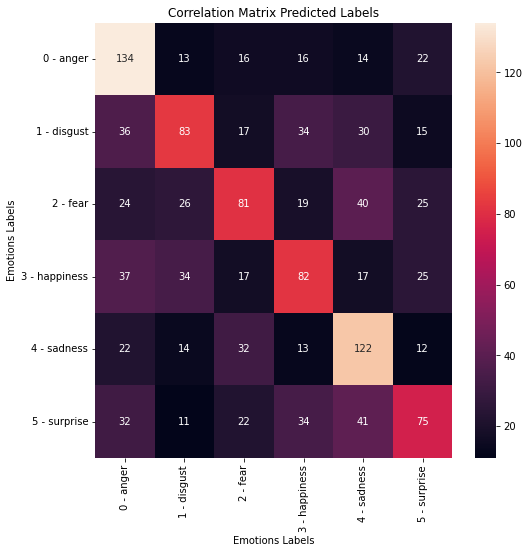

In [17]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), df[df.columns[4:]].values, labels)

## 1.1 - With high correlation elimination

accuracy:  0.4763014763014763
f1 score macro:  0.46805818711878605
f1 score micro:  0.4763014763014763
precision score:  0.47099242994240303
recall score:  0.4761701038467163
hamming_loss:  0.5236985236985237
matthews_corrcoef:  0.37333283159435704
zero_one_loss:  0.5236985236985237
               precision    recall  f1-score   support

    0 - anger       0.50      0.68      0.58       215
  1 - disgust       0.46      0.36      0.40       215
     2 - fear       0.45      0.38      0.41       215
3 - happiness       0.47      0.42      0.44       212
  4 - sadness       0.51      0.64      0.57       215
 5 - surprise       0.43      0.38      0.40       215

     accuracy                           0.48      1287
    macro avg       0.47      0.48      0.47      1287
 weighted avg       0.47      0.48      0.47      1287



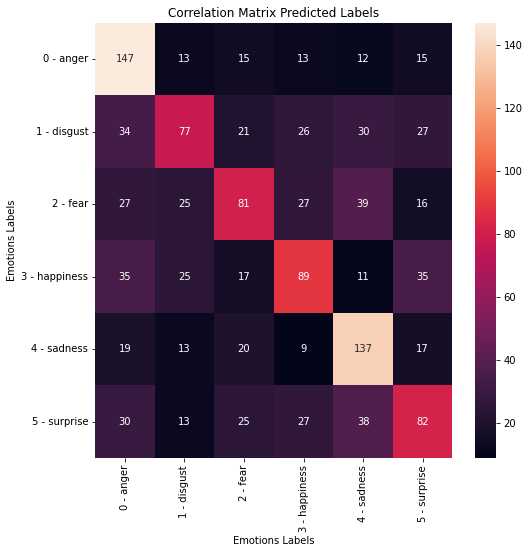

In [92]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data.values, labels)

## 1.1.1 With All Principal Components

accuracy:  0.4568764568764569
f1 score macro:  0.44817264573364496
f1 score micro:  0.4568764568764569
precision score:  0.45395212920455713
recall score:  0.4569109258446687
hamming_loss:  0.5431235431235432
matthews_corrcoef:  0.35037842779208267
zero_one_loss:  0.543123543123543
               precision    recall  f1-score   support

    0 - anger       0.48      0.62      0.54       215
  1 - disgust       0.39      0.34      0.36       215
     2 - fear       0.50      0.33      0.40       215
3 - happiness       0.40      0.47      0.43       212
  4 - sadness       0.53      0.65      0.58       215
 5 - surprise       0.42      0.32      0.36       215

     accuracy                           0.46      1287
    macro avg       0.45      0.46      0.45      1287
 weighted avg       0.45      0.46      0.45      1287



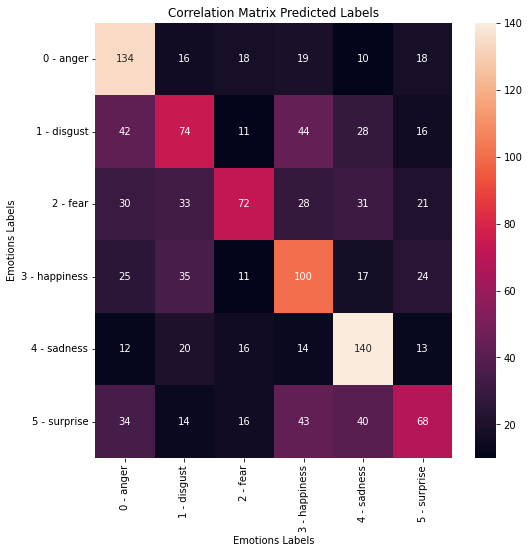

In [93]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data_pca, labels)

## 1.1.2 - With an Ideal Number of Principal Components

accuracy:  0.4405594405594406
f1 score macro:  0.4344298611674208
f1 score micro:  0.4405594405594405
precision score:  0.43702486155296333
recall score:  0.4405550680122861
hamming_loss:  0.5594405594405595
matthews_corrcoef:  0.3299745831390555
zero_one_loss:  0.5594405594405594
               precision    recall  f1-score   support

    0 - anger       0.45      0.58      0.51       215
  1 - disgust       0.38      0.35      0.37       215
     2 - fear       0.47      0.36      0.41       215
3 - happiness       0.40      0.44      0.42       212
  4 - sadness       0.52      0.61      0.56       215
 5 - surprise       0.40      0.31      0.35       215

     accuracy                           0.44      1287
    macro avg       0.44      0.44      0.43      1287
 weighted avg       0.44      0.44      0.43      1287



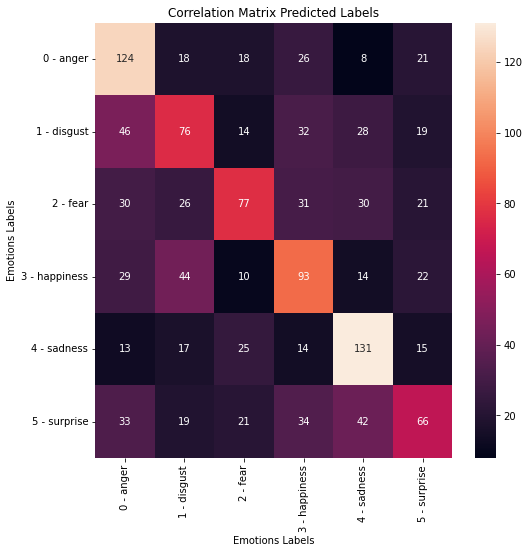

In [94]:
pca = PCA(n_components=num_component)
data_pca_ideal_comp = pca.fit_transform(data_scaled)
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data_pca_ideal_comp, labels)

## 1.1.3 - With Feature Elimination with Backward Propagation

accuracy:  0.3395493395493395
f1 score macro:  0.3360801713731056
f1 score micro:  0.3395493395493395
precision score:  0.3365954319532218
recall score:  0.339297206377066
hamming_loss:  0.6604506604506605
matthews_corrcoef:  0.20786222063241924
zero_one_loss:  0.6604506604506605
               precision    recall  f1-score   support

    0 - anger       0.36      0.32      0.34       215
  1 - disgust       0.31      0.33      0.32       215
     2 - fear       0.39      0.50      0.44       215
3 - happiness       0.26      0.23      0.25       212
  4 - sadness       0.33      0.33      0.33       215
 5 - surprise       0.36      0.32      0.34       215

     accuracy                           0.34      1287
    macro avg       0.34      0.34      0.34      1287
 weighted avg       0.34      0.34      0.34      1287



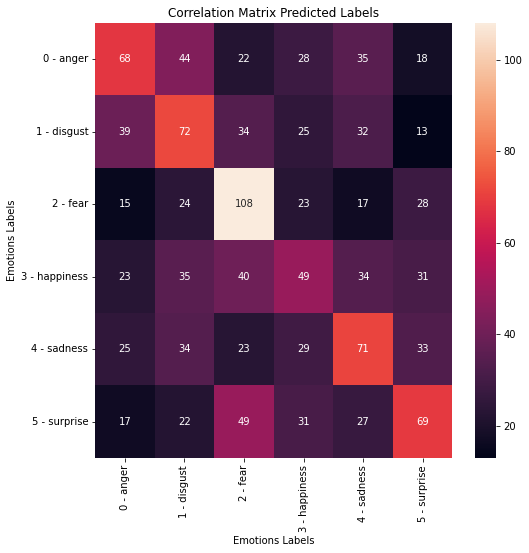

In [95]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data_elim_feats.values, labels)

## 1.1.3.1 - With All Principal Components

accuracy:  0.33644133644133645
f1 score macro:  0.3333892979517273
f1 score micro:  0.33644133644133645
precision score:  0.33501121363237035
recall score:  0.33624031007751937
hamming_loss:  0.6635586635586636
matthews_corrcoef:  0.20419523300348488
zero_one_loss:  0.6635586635586636
               precision    recall  f1-score   support

    0 - anger       0.36      0.39      0.37       215
  1 - disgust       0.31      0.32      0.31       215
     2 - fear       0.36      0.46      0.40       215
3 - happiness       0.30      0.25      0.27       212
  4 - sadness       0.31      0.30      0.31       215
 5 - surprise       0.37      0.30      0.33       215

     accuracy                           0.34      1287
    macro avg       0.34      0.34      0.33      1287
 weighted avg       0.34      0.34      0.33      1287



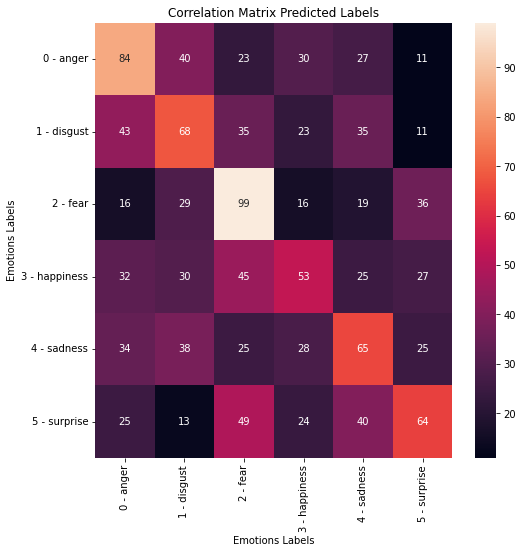

In [96]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_pca_elim, labels
)

## 1.3.1.2 - With an Ideal Number of Principal Components

accuracy:  0.32167832167832167
f1 score macro:  0.3184364703353669
f1 score micro:  0.32167832167832167
precision score:  0.3193480495914953
recall score:  0.3215006581834137
hamming_loss:  0.6783216783216783
matthews_corrcoef:  0.1864160778104617
zero_one_loss:  0.6783216783216783
               precision    recall  f1-score   support

    0 - anger       0.32      0.35      0.33       215
  1 - disgust       0.31      0.33      0.32       215
     2 - fear       0.37      0.46      0.41       215
3 - happiness       0.28      0.25      0.26       212
  4 - sadness       0.30      0.26      0.28       215
 5 - surprise       0.34      0.28      0.31       215

     accuracy                           0.32      1287
    macro avg       0.32      0.32      0.32      1287
 weighted avg       0.32      0.32      0.32      1287



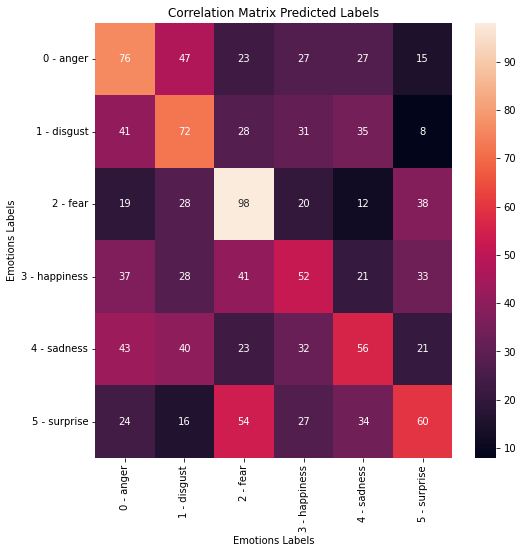

In [97]:
pca = PCA(n_components=num_component_elim)
data_pca_elim_ideal_comp = pca.fit_transform(data_scaled_elim)
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_pca_elim_ideal_comp, labels
)

## 1.3.1.2 - One vs Rest Classifier

accuracy:  0.34498834498834496
f1 score macro:  0.34381748404813867
f1 score micro:  0.34498834498834496
precision score:  0.34554436007042355
recall score:  0.344800351031154
hamming_loss:  0.655011655011655
matthews_corrcoef:  0.21431011856089432
zero_one_loss:  0.655011655011655
               precision    recall  f1-score   support

    0 - anger       0.40      0.34      0.37       215
  1 - disgust       0.38      0.38      0.38       215
     2 - fear       0.34      0.43      0.38       215
3 - happiness       0.28      0.26      0.27       212
  4 - sadness       0.34      0.33      0.33       215
 5 - surprise       0.33      0.32      0.33       215

     accuracy                           0.34      1287
    macro avg       0.35      0.34      0.34      1287
 weighted avg       0.35      0.34      0.34      1287



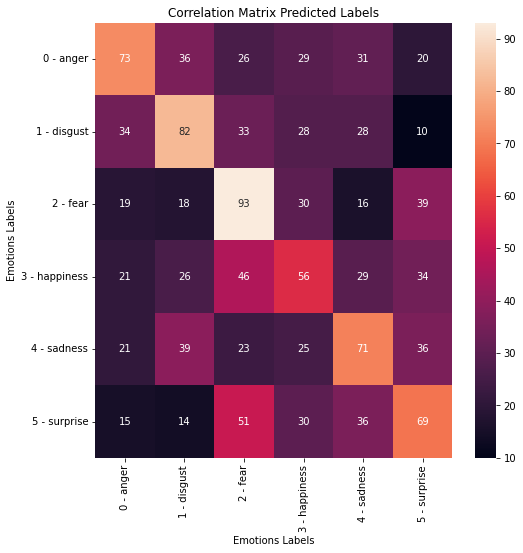

In [98]:
plot_cm_predictions(
    OneVsRestClassifier(RandomForest(random_state=1, max_features=None)),
    data_elim_feats.values, labels
)

## Valence and Arousal

In [99]:
display(HTML('<a href="https://www.researchgate.net/figure/Emotions-in-valence-arousal-space-13_fig3_329718637"><img src="https://www.researchgate.net/profile/Ananya-Bhattacharjee/publication/329718637/figure/fig3/AS:704946219532291@1545083684893/Emotions-in-valence-arousal-space-13.ppm" alt="Emotions in valence-arousal space [13]"/></a>'))

In [18]:
emotions = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise'
}
emo_val = {
    'anger': 0,
    'disgust': 0,
    'fear': 0,
    'happiness': 1,
    'sadness': 0,
    'surprise': 1
}
emo_aro = {
    'anger': 1,
    'disgust': 1,
    'fear': 1,
    'happiness': 1,
    'sadness': 0,
    'surprise': 1
}
multi_pred = {
    (0, 0): 0,
    (0, 1): 1,
    (1, 1): 2
}
labels_val = [emo_val[emotions[e]] for e in labels]
labels_aro = [emo_aro[emotions[e]] for e in labels]
labels_val_aro = [multi_pred[(emo_val[emotions[e]], emo_aro[emotions[e]])] for e in labels]

## Classification for valence only

accuracy:  0.6767676767676768
f1 score macro:  0.5896498865656998
f1 score micro:  0.6767676767676768
precision score:  0.6191231548799295
recall score:  0.5883448613909917
hamming_loss:  0.32323232323232326
matthews_corrcoef:  0.20517230423548902
zero_one_loss:  0.3232323232323232
                  precision    recall  f1-score   support

 0 - Low Valence       0.72      0.85      0.78       860
1 - High Valence       0.52      0.33      0.40       427

        accuracy                           0.68      1287
       macro avg       0.62      0.59      0.59      1287
    weighted avg       0.65      0.68      0.65      1287



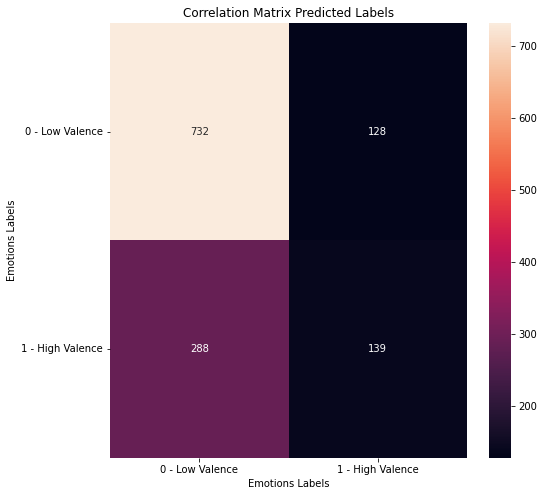

In [101]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_elim_feats.values, labels_val, val=True
)

## Classification for arousal only

accuracy:  0.8251748251748252
f1 score macro:  0.5742952699474438
f1 score micro:  0.8251748251748252
precision score:  0.6462563828523928
recall score:  0.5641248698368622
hamming_loss:  0.17482517482517482
matthews_corrcoef:  0.1936870828240229
zero_one_loss:  0.1748251748251748
                  precision    recall  f1-score   support

 0 - Low Arousal       0.44      0.17      0.25       215
1 - High Arousal       0.85      0.96      0.90      1072

        accuracy                           0.83      1287
       macro avg       0.65      0.56      0.57      1287
    weighted avg       0.78      0.83      0.79      1287



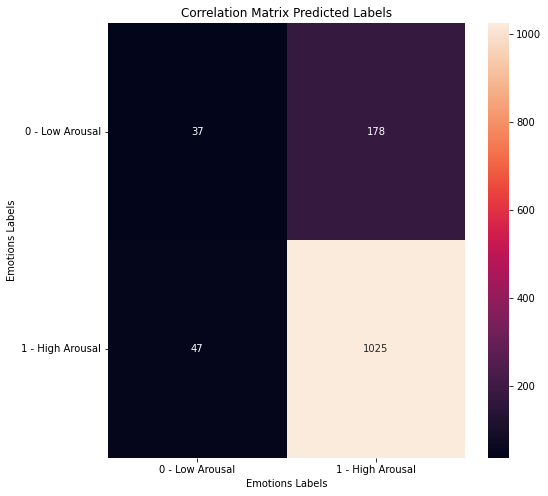

In [102]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_elim_feats.values, labels_aro, aro=True
)

## Classification for valence and arousal

accuracy:  0.6122766122766122
f1 score macro:  0.560843045519993
f1 score micro:  0.6122766122766122
precision score:  0.5905890075487894
recall score:  0.549134941815079
hamming_loss:  0.3877233877233877
matthews_corrcoef:  0.3432360585229307
zero_one_loss:  0.38772338772338777
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.53      0.40      0.46       215
(0, 1) - anger, disgust, fear       0.63      0.78      0.70       645
 (1, 1) - happiness, surprise       0.61      0.46      0.52       427

                     accuracy                           0.61      1287
                    macro avg       0.59      0.55      0.56      1287
                 weighted avg       0.61      0.61      0.60      1287



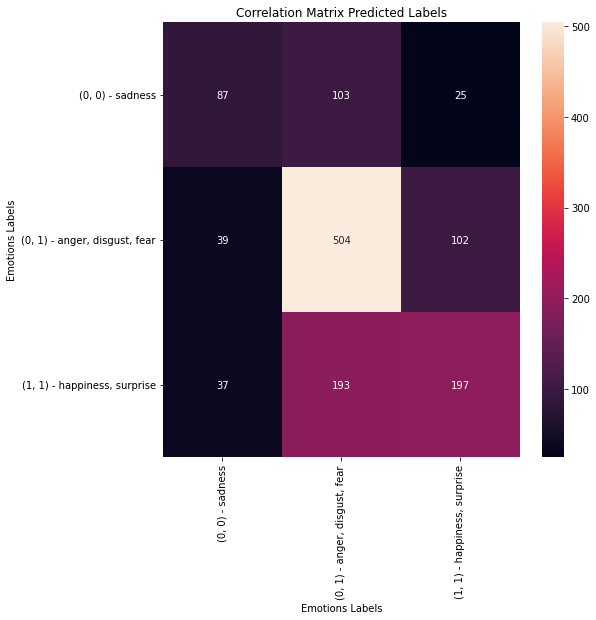

In [42]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

## Balanced Trees

accuracy:  0.5734265734265734
f1 score macro:  0.566620221140149
f1 score micro:  0.5734265734265734
precision score:  0.5619006902572927
recall score:  0.6090372710273587
hamming_loss:  0.42657342657342656
matthews_corrcoef:  0.3543227050884706
zero_one_loss:  0.42657342657342656
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.42      0.74      0.54       215
(0, 1) - anger, disgust, fear       0.69      0.53      0.60       645
 (1, 1) - happiness, surprise       0.58      0.55      0.57       427

                     accuracy                           0.57      1287
                    macro avg       0.56      0.61      0.57      1287
                 weighted avg       0.61      0.57      0.58      1287



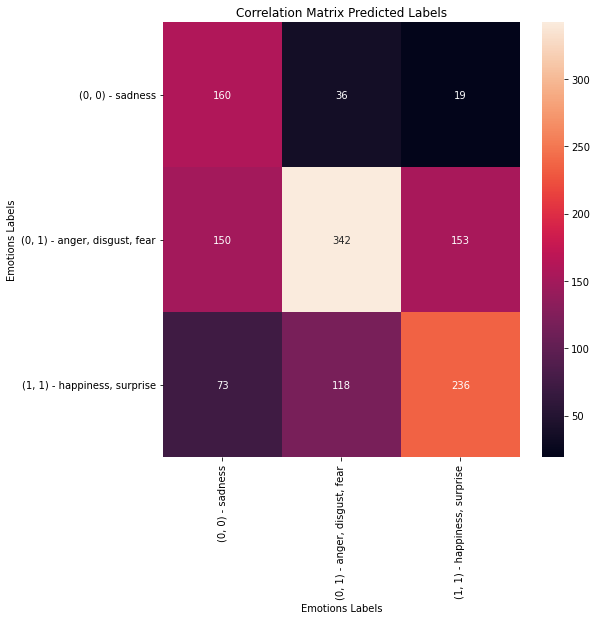

In [48]:
plot_cm_predictions(
    BalancedRandomForestClassifier(random_state=1, max_features=None),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.6045066045066045
f1 score macro:  0.5914730437871925
f1 score micro:  0.6045066045066045
precision score:  0.5828077028077027
recall score:  0.6186252261738346
hamming_loss:  0.3954933954933955
matthews_corrcoef:  0.38283303035126887
zero_one_loss:  0.39549339549339546
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.46      0.69      0.55       215
(0, 1) - anger, disgust, fear       0.70      0.60      0.65       645
 (1, 1) - happiness, surprise       0.59      0.56      0.58       427

                     accuracy                           0.60      1287
                    macro avg       0.58      0.62      0.59      1287
                 weighted avg       0.62      0.60      0.61      1287



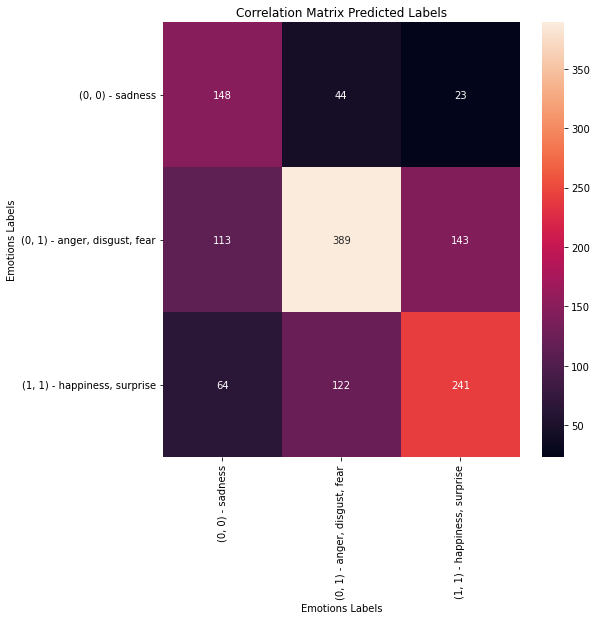

In [50]:
plot_cm_predictions(
    BalancedBaggingClassifier(
        RandomForest(random_state=1, max_features=None), 100, random_state=1, n_jobs=8
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.585081585081585
f1 score macro:  0.5769614224043186
f1 score micro:  0.585081585081585
precision score:  0.5736176293018773
recall score:  0.6194276516045483
hamming_loss:  0.4149184149184149
matthews_corrcoef:  0.3744632174985822
zero_one_loss:  0.41491841491841497
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.42      0.74      0.53       215
(0, 1) - anger, disgust, fear       0.71      0.54      0.61       645
 (1, 1) - happiness, surprise       0.59      0.58      0.59       427

                     accuracy                           0.59      1287
                    macro avg       0.57      0.62      0.58      1287
                 weighted avg       0.62      0.59      0.59      1287



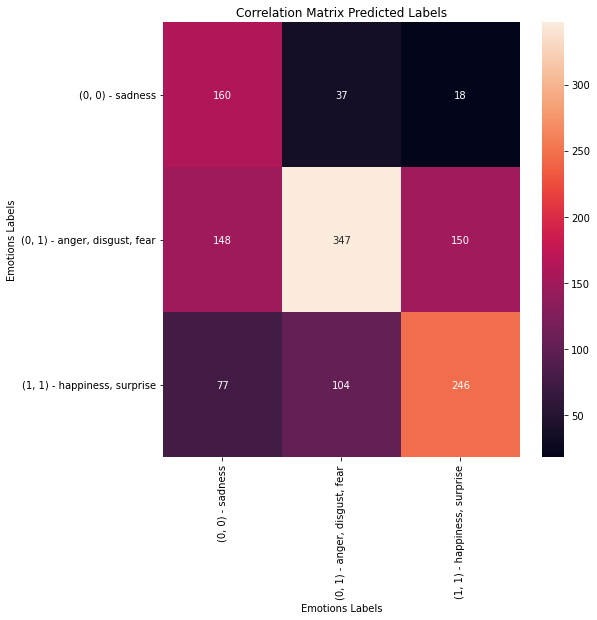

In [51]:
plot_cm_predictions(
    EasyEnsembleClassifier(
        100, RandomForest(random_state=1, max_features=None), random_state=1, n_jobs=8
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.5633255633255633
f1 score macro:  0.49008190779828337
f1 score micro:  0.5633255633255633
precision score:  0.545259794763164
recall score:  0.4784670406477498
hamming_loss:  0.4366744366744367
matthews_corrcoef:  0.24324149471748555
zero_one_loss:  0.43667443667443673
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.52      0.26      0.35       215
(0, 1) - anger, disgust, fear       0.58      0.77      0.66       645
 (1, 1) - happiness, surprise       0.53      0.41      0.46       427

                     accuracy                           0.56      1287
                    macro avg       0.55      0.48      0.49      1287
                 weighted avg       0.55      0.56      0.54      1287



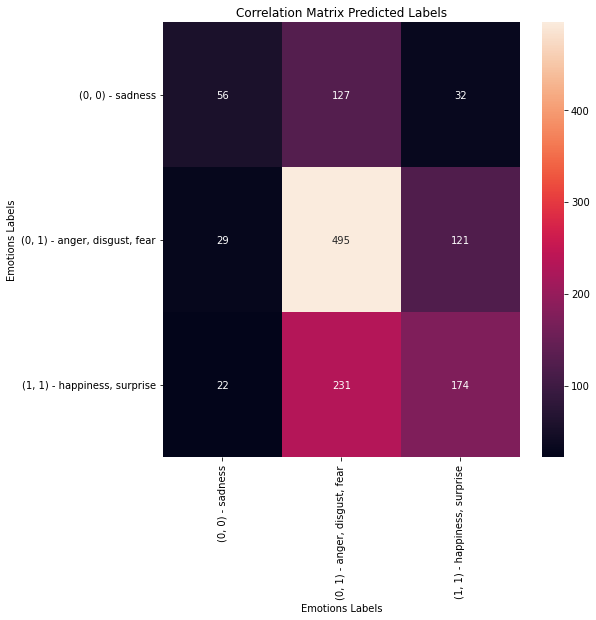

In [52]:
plot_cm_predictions(
    RUSBoostClassifier(
        RandomForest(random_state=1, max_features=None, n_jobs=8), n_estimators=100, random_state=1
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

## Simple Deep Learning

### Model

In [23]:
def build_model_0(input_shape=(12, 1)):
    model = Sequential()
    model.add(Conv1D(64, 5, input_shape=input_shape))
    model.add(Activation('relu'))#2nd hidden layer
    model.add(Conv1D(64, 5, padding="same"))
    model.add(Activation('relu'))#3rd hidden layer
    model.add(Conv1D(64, 5, padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))#Add fully connected layer.
    model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dense(3))
    model.add(Activation('softmax'))
    # Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
build_model_0(input_shape=(data_elim_feats.shape[1], 1)).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 8, 64)             384       
                                                                 
 activation_5 (Activation)   (None, 8, 64)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 64)             20544     
                                                                 
 activation_6 (Activation)   (None, 8, 64)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 8, 64)             20544     
                                                                 
 activation_7 (Activation)   (None, 8, 64)             0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 64)            

In [25]:
def build_model_1(input_shape=(12, 1)):
    model = Sequential()
    model.add(Conv1D(256, 5,padding='same', input_shape=input_shape)) #1
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #2
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 5,padding='same')) #3
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #6
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(3)) #7
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
build_model_1(input_shape=(data_elim_feats.shape[1], 1)).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 12, 256)           1536      
                                                                 
 activation_9 (Activation)   (None, 12, 256)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 12, 128)           163968    
                                                                 
 activation_10 (Activation)  (None, 12, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 12, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                      

### Compile and fit model

### Accuracy metric to evaluate performance, using adam optimizer, and categorical crossentropy as the loss function

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_919/858656607.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.54001554001554
f1 score macro:  0.508129066093229
f1 score micro:  0.54001554001554
precision score:  0.5120188669073639
recall score:  0.5056696258373726
hamming_loss:  0.45998445998445997
matthews_corrcoef:  0.23799769904171622
zero_one_loss:  0.45998445998446
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.46      0.44      0.45       215
(0, 1) - anger, disgust, fear       0.60      0.64      0.62       645
 (1, 1) - happiness, surprise       0.48      0.44      0.46       427

                     accuracy                           0.54      1287
                    macro avg       0.51      0.51      0.51      1287
                 weighted avg       0.54      0.54      0.54      1287



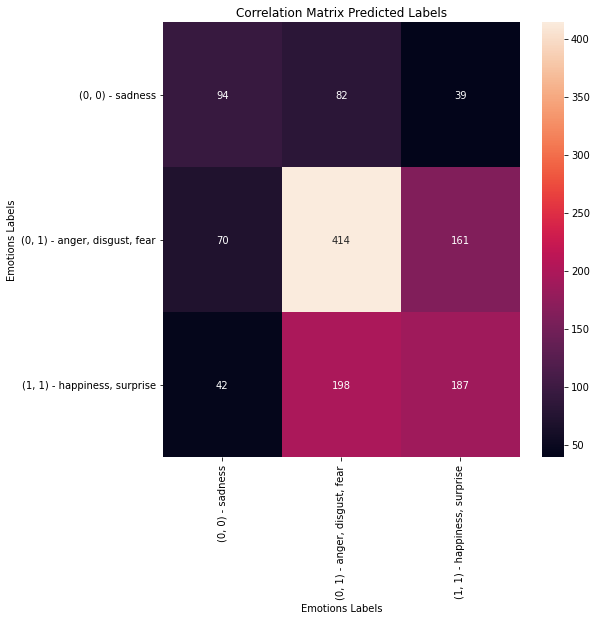

In [33]:
one_hot_encoding = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
}
one_hot_labels_val_aro = [one_hot_encoding[i] for i in labels_val_aro]

plot_cm_predictions(estimator, data_elim_feats, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_919/42186902.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.5275835275835276
f1 score macro:  0.4924571281965062
f1 score micro:  0.5275835275835276
precision score:  0.4985750785867726
recall score:  0.493092242615689
hamming_loss:  0.47241647241647244
matthews_corrcoef:  0.21325556080122193
zero_one_loss:  0.47241647241647244
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.45      0.46      0.45       215
(0, 1) - anger, disgust, fear       0.58      0.66      0.62       645
 (1, 1) - happiness, surprise       0.47      0.36      0.41       427

                     accuracy                           0.53      1287
                    macro avg       0.50      0.49      0.49      1287
                 weighted avg       0.52      0.53      0.52      1287



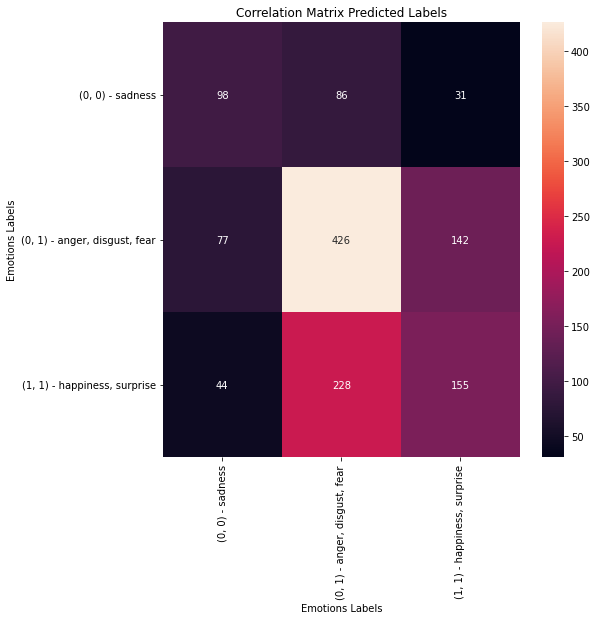

In [34]:
estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

plot_cm_predictions(estimator, data_elim_feats, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))